In [1]:
# ============================================
# LIBRARIES & DIRECTORIES, LOADS DATA
# =============================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve

DATA_PATH = os.path.join("..", "data", "processed", "flux_with_features.csv")
df = pd.read_csv(DATA_PATH)
df["time"] = pd.to_datetime(df["time"])

In [2]:
# ============================================
# DEFINES FEATURE COLUMNS & TARGETS
# =============================================

manual_features = [
    "xrsb_flux_log",
    "flux_diff_5min",
    "flux_rate",
    "flux_acceleration",
    "flux_max_diff_5min",
    "rolling_avg_5min", "rolling_min_5min", "rolling_max_5min", "rolling_std_5min",
    "rolling_avg_15min", "rolling_min_15min", "rolling_max_15min", "rolling_std_15min",
    "rolling_avg_30min", "rolling_min_30min", "rolling_max_30min", "rolling_std_30min",
    "rolling_avg_60min", "rolling_min_60min", "rolling_max_60min", "rolling_std_60min",
    "rolling_slope_30min",
    "flux_above_background",
    "flux_rising",
    "rising_streak"
]
feature_cols = [col for col in df.columns if "lag_" in col] + manual_features

# These are the time-target columns, or 'horizons'
targets = {
    "6h": "flare_in_next_6h",
    "12h": "flare_in_next_12h",
    "18h": "flare_in_next_18h",
    "24h": "flare_in_next_24h"
}


== Training for next 6h flare prediction ==
scale_pos_weight: 1.13
Fitting...
Predicting...
Best threshold for F1: 0.47
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.93      0.79      0.85    457506
           1       0.79      0.93      0.86    403902

    accuracy                           0.85    861408
   macro avg       0.86      0.86      0.85    861408
weighted avg       0.87      0.85      0.85    861408

=== Confusion Matrix ===
[[359163  98343]
 [ 27389 376513]]
Accuracy: 0.854
F1 Score: 0.857
ROC AUC: 0.923


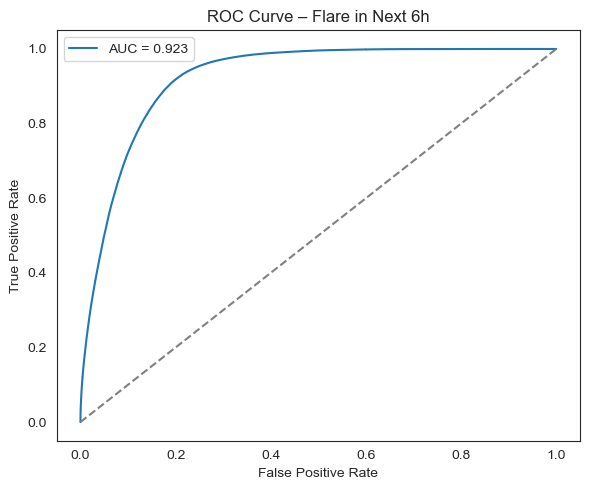

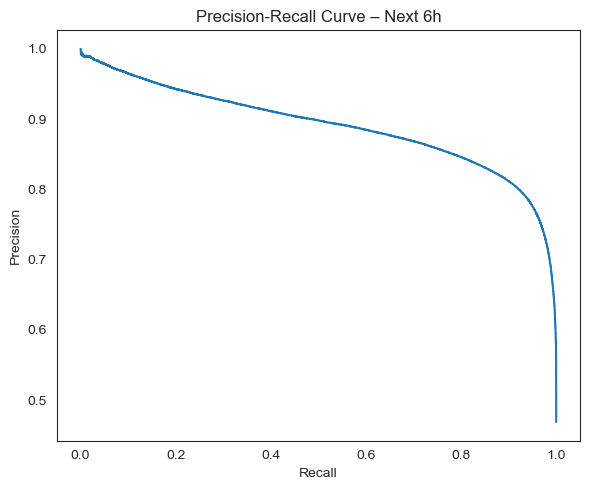

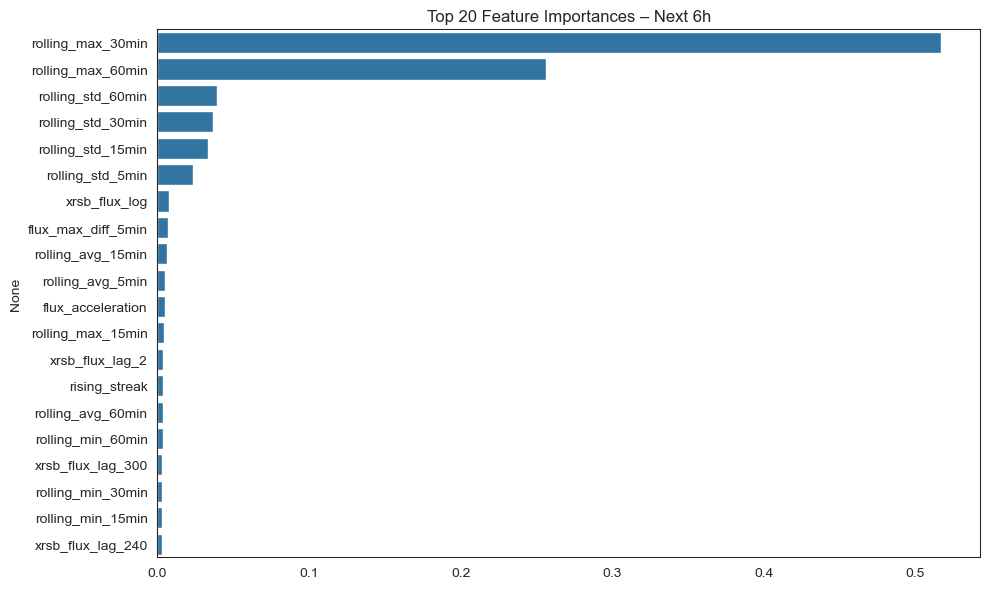


== Training for next 12h flare prediction ==
scale_pos_weight: 0.84
Fitting...
Predicting...
Best threshold for F1: 0.41
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.91      0.83      0.87    392967
           1       0.87      0.93      0.90    468441

    accuracy                           0.89    861408
   macro avg       0.89      0.88      0.88    861408
weighted avg       0.89      0.89      0.88    861408

=== Confusion Matrix ===
[[327884  65083]
 [ 33964 434477]]
Accuracy: 0.885
F1 Score: 0.898
ROC AUC: 0.943


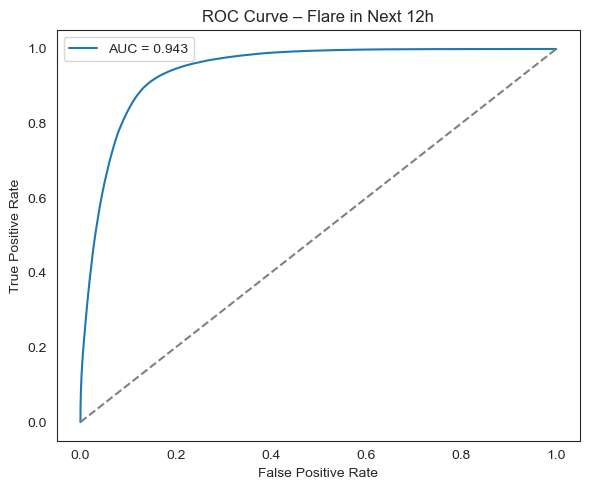

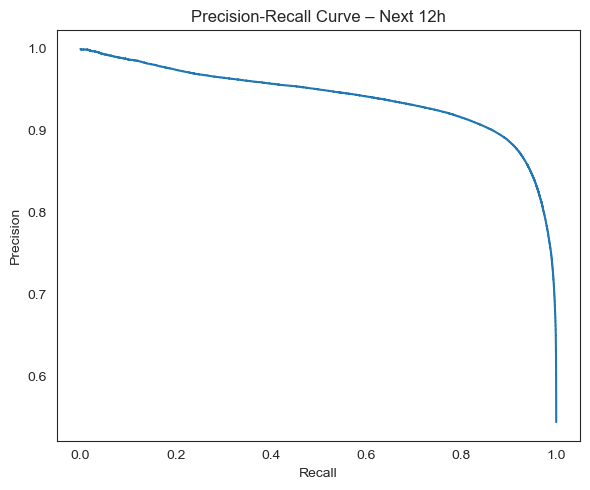

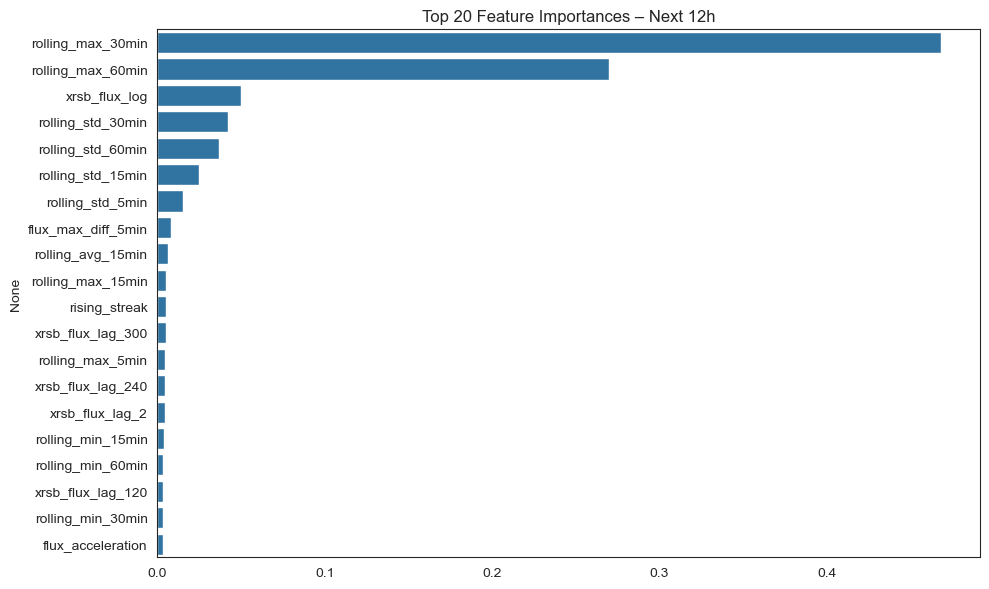


== Training for next 18h flare prediction ==
scale_pos_weight: 0.71
Fitting...
Predicting...
Best threshold for F1: 0.35
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.90      0.84      0.87    358098
           1       0.89      0.93      0.91    503310

    accuracy                           0.90    861408
   macro avg       0.90      0.89      0.89    861408
weighted avg       0.90      0.90      0.90    861408

=== Confusion Matrix ===
[[302443  55655]
 [ 33812 469498]]
Accuracy: 0.896
F1 Score: 0.913
ROC AUC: 0.952


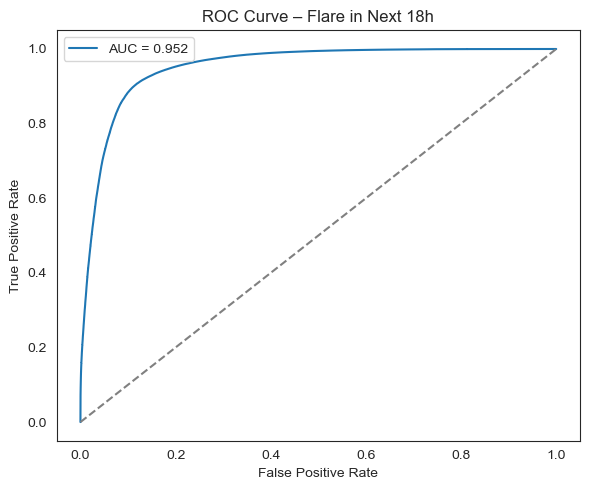

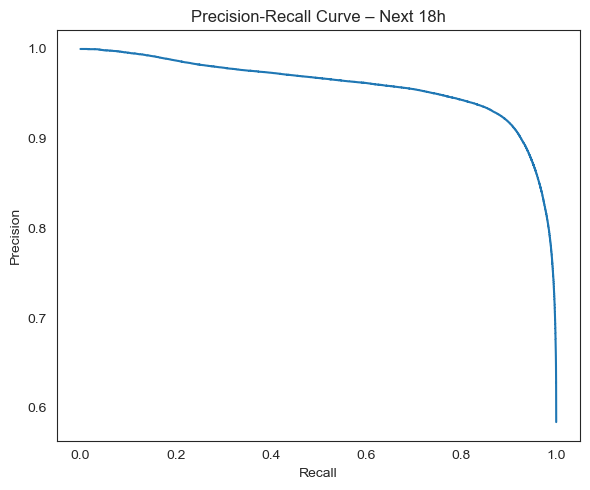

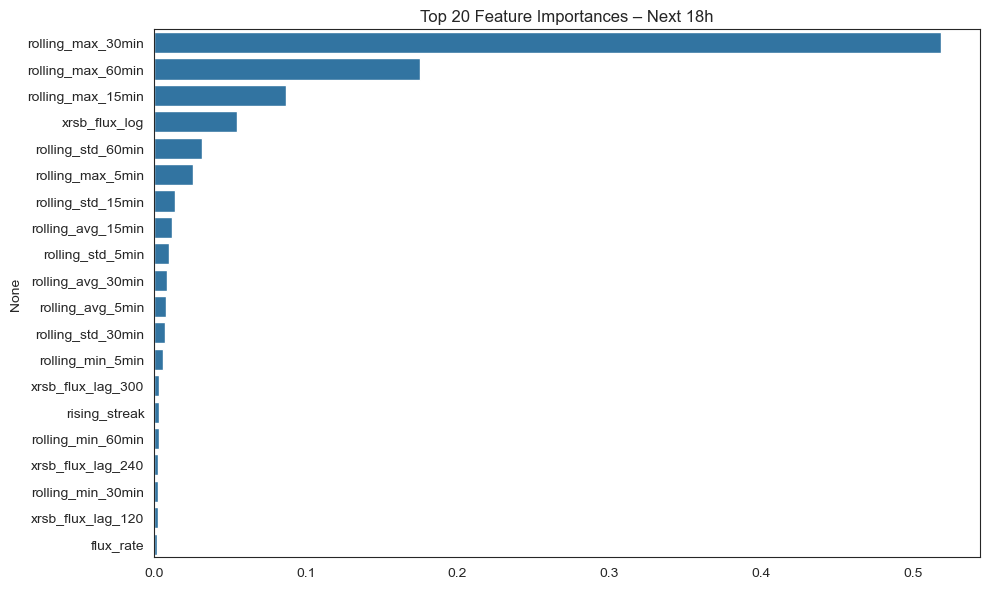


== Training for next 24h flare prediction ==
scale_pos_weight: 0.63
Fitting...
Predicting...
Best threshold for F1: 0.35
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.89      0.86      0.88    332220
           1       0.92      0.93      0.92    529188

    accuracy                           0.91    861408
   macro avg       0.90      0.90      0.90    861408
weighted avg       0.90      0.91      0.90    861408

=== Confusion Matrix ===
[[287291  44929]
 [ 36807 492381]]
Accuracy: 0.905
F1 Score: 0.923
ROC AUC: 0.960


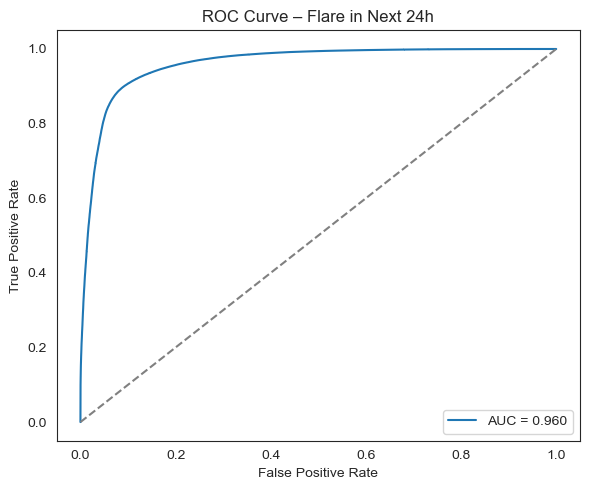

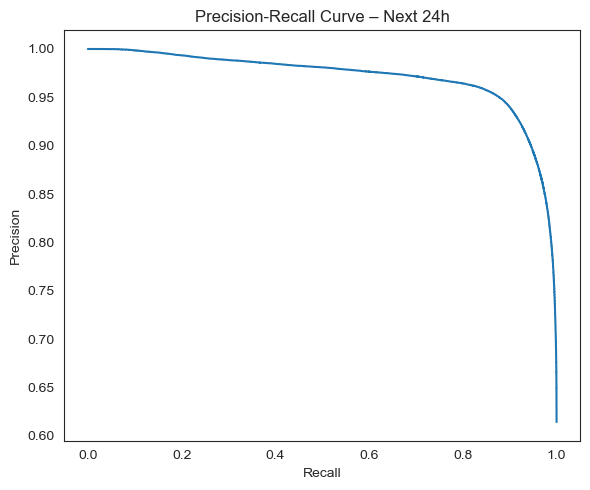

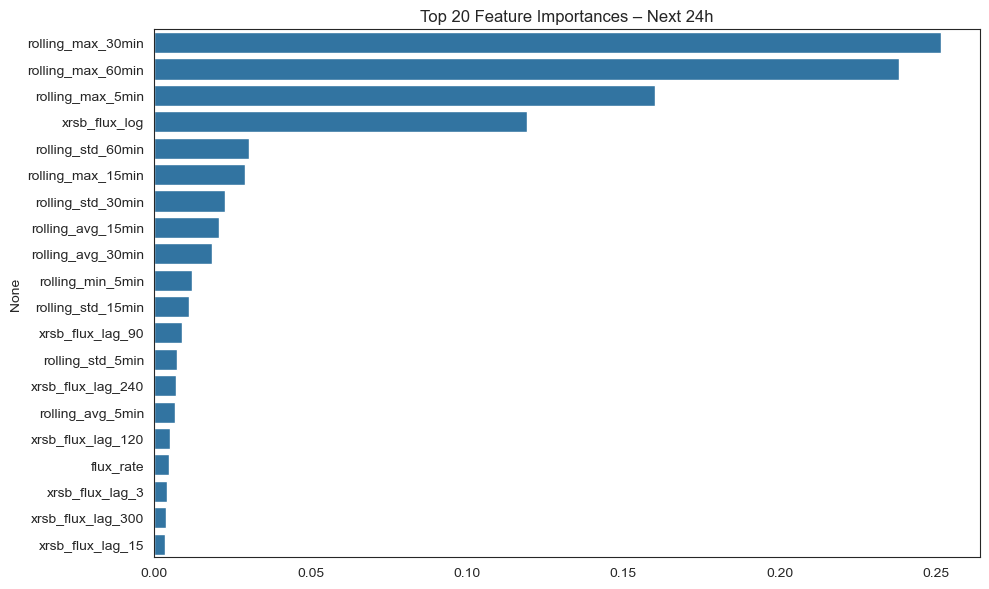

In [ ]:
# ============================================
# RUNS MODEL FOR EACH TIME HORIZON & EVALUATES
# =============================================

for label, target_col in targets.items():
    print(f"\n================================================")
    print(f"== Training for next {label} flare prediction ==")
    print(f"================================================")

    # Sets features and targets
    X = df[feature_cols]
    y = df[target_col]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=3, stratify=y
    )

    # Sets scale_pos_weight as a ratio of non-flares to flares
    # XGBoost has this as a parameter to help compensate for imbalanced classes
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    print(f"scale_pos_weight: {scale_pos_weight:.2f}")

    # Trains model
    clf = xgb.XGBClassifier(
        n_estimators=200, # number of trees to build
        learning_rate=0.05, # contribution of each tree
        max_depth=6, # max depth of each tree
        scale_pos_weight=scale_pos_weight, 
        eval_metric="logloss", # logarithmic loss b/c of large values
        n_jobs=-1, # enables parallel training to use all available CPU cores
        verbosity=0, # no info printed while training
        random_state=3
    )

    print("Fitting...")
    clf.fit(X_train, y_train)

    print("Predicting...")
    y_proba = clf.predict_proba(X_test)[:, 1]

    # Finds the best threshold for F1-score
    thresholds = np.linspace(0, 1, 101)
    f1_scores = [f1_score(y_test, y_proba > t) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Best threshold for F1: {best_threshold:.2f}")

    # Creates adjusted predictions (y_pred_adj) with the new threshold
    y_pred_adj = (y_proba > best_threshold).astype(int)

    # Evaluation
    print("=== Classification Report ===")
    print(classification_report(y_test, y_pred_adj))

    print("=== Confusion Matrix ===")
    print(confusion_matrix(y_test, y_pred_adj))

    print(f"Accuracy: {accuracy_score(y_test, y_pred_adj):.3f}")
    print(f"F1 Score: {f1_score(y_test, y_pred_adj):.3f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    sns.set_style('white')
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – Flare in Next {label}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Precision-Recall score
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    sns.set_style('white')
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve – Next {label}")
    plt.tight_layout()
    plt.show()

    # Feature importance
    importances = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    sns.set_style('white')
    sns.barplot(x=importances.values[:20], y=importances.index[:20]) # only top 20
    plt.title(f"Top 20 Feature Importances – Next {label}")
    plt.tight_layout()
    plt.show()